# In this project we will build a Machine Learning model to predict whether an indiviudal will have a stroke.  The data used in this project can be found on kaggle at the following link: https://www.kaggle.com/asaumya/healthcare-data#train_2v.csv

# In this notebook, we perform our initial data analysis to better understand the data.

# To view the building and implementation of our Machine Learning model,  please see the notebook titled "Machine_Learning."

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import os

# Define file path to original csv file
original_data_file_path = os.path.join("..", "Data", "train_2v.csv")

# Create dataframe from local csv file
stroke_data_original =pd.read_csv(original_data_file_path)

# We will start by preview our data and determing what kind of problem we have. 

In [3]:
# Preview dataframe
stroke_data_original.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0


In [4]:
# Get shape of dataframe
stroke_data_original.shape

(43400, 12)

In [5]:
# Get the number of indiviudals who had a stroke.
number_of_people_who_had_a_stroke = len(stroke_data_original[stroke_data_original["stroke"] == 1])
number_of_people_who_had_a_stroke

783

In [6]:
# Get the percentage of people who had a stroke
percentage_of_people_who_had_a_stroke = (number_of_people_who_had_a_stroke / len(stroke_data_original) ) * 100
percentage_of_people_who_had_a_stroke

1.804147465437788

 # After previewing our data, we see that we have a classification problem.  We will determine what the most appropriate features are, and use these to predict whether an individual will have a stroke.
 
 # We also notice that only about 1.8% of the individuals in our dataset had a stroke.  We will have to find a way to deal with imbalanced data.

# 1. Prework / Data Cleansing

In [7]:
# We do not want to work with unique identifiers.
# We will therefore drop the id column.

stroke_data_clean = stroke_data_original.drop(["id"], axis=1)
stroke_data_clean.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0


In [8]:
# Check for NaN values
stroke_data_clean.isna().sum()

gender                   0
age                      0
hypertension             0
heart_disease            0
ever_married             0
work_type                0
Residence_type           0
avg_glucose_level        0
bmi                   1462
smoking_status       13292
stroke                   0
dtype: int64

In [9]:
# Get number of unique values in smoking_status column
stroke_data_clean["smoking_status"].nunique()

3

In [10]:
# Get unique values of smoking_status column
stroke_data_clean["smoking_status"].unique()

array([nan, 'never smoked', 'formerly smoked', 'smokes'], dtype=object)

In [11]:
# Get number of unique values in bmi column
stroke_data_clean["bmi"].nunique()

555

## We are working with NaN data.  We have a few options for what to do.

### Concerning the bmi values, we could:

1. Fill NaN values with the mean bmi value
1. Fill NaN values with the median bmi value
1. Fill NaN values with the mode bmi value

In [12]:
print(f"Mean bmi: {stroke_data_clean['bmi'].mean()}")
print(f"Median bmi: {stroke_data_clean['bmi'].median()}")
print(f"Mode bmi: {stroke_data_clean.mode()['bmi'][0]}")

Mean bmi: 28.605038390004545
Median bmi: 27.7
Mode bmi: 27.7


In [13]:
# The median bmi values is equal to the mode bmi value
# Fill NaN values in the "bmi" column with the median bmi
stroke_data_clean["bmi"].fillna(stroke_data_clean["bmi"].median(), inplace=True)

In [14]:
# Confirm no NaN values in the "bmi" column
stroke_data_clean.isna().sum()

gender                   0
age                      0
hypertension             0
heart_disease            0
ever_married             0
work_type                0
Residence_type           0
avg_glucose_level        0
bmi                      0
smoking_status       13292
stroke                   0
dtype: int64

### Concerning the smoking_status values, we will use one hot encoding once we get to the Machine Learning notebook.  As such, we will not fill in these NaNs; these fields will neither add to nor take away from the Machine Learning model.

## 2. Data Exploration

In [15]:
# Get the data type for each column
print("Assume smokes")
print(stroke_data_clean.dtypes)

Assume smokes
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object


In [16]:
# Create list of possible categorical features
possible_categorical_features = ["gender",
                                 "hypertension",
                                 "heart_disease",
                                 "ever_married",
                                 "work_type",
                                 "Residence_type",
                                 "smoking_status"]

# Create list of possible numerical features
possible_numerical_features = ["age",
                               "avg_glucose_level",
                               "bmi"]

Text(0.5,1,'Count of individuals who had a stroke\n1 correponds to "had a stroke"')

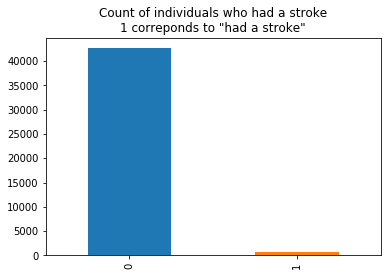

In [17]:
# Visualize how many people did and did not have a stroke

stroke_data_clean.stroke.value_counts().plot(kind="bar")
plt.title("Count of individuals who had a stroke\n1 correponds to \"had a stroke\"")

### Categorical Analysis
#### For each categorical feature, we will graph two bar plots- one for the entire dataset, and one for filtering the data to just those who had a stroke.  We will then examine the actual percentages that each group in each category makes up.

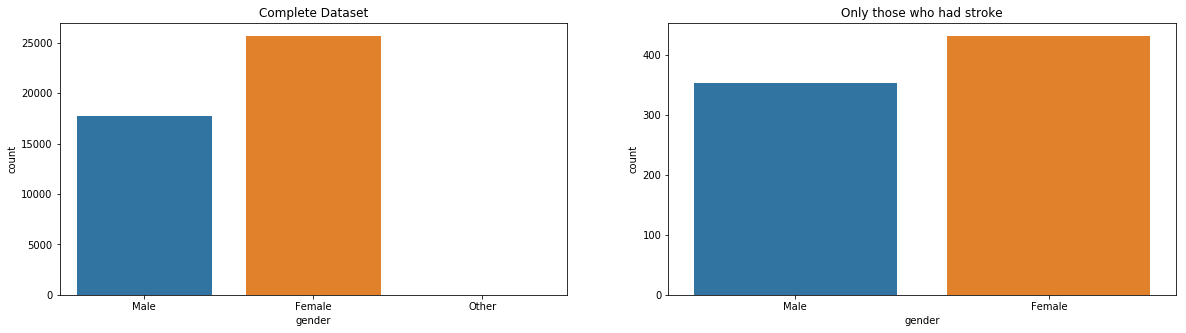

In [18]:
# Define a figure,
# so that we can make two subplots
# one for the complete dataset,
# and one for filtering the data to just those who had a stroke
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
sns.countplot(stroke_data_clean["gender"])
plt.title("Complete Dataset")

plt.subplot(1,2,2)
sns.countplot(stroke_data_clean[stroke_data_clean["stroke"] == 1]["gender"])
plt.title("Only those who had stroke")

plt.show()

In [19]:
# Get the exact number of people in each group of the entire dataset
print(stroke_data_clean["gender"].value_counts())

# Get the exact number of people in each group,
# after filtering to just those who had a stroke
print(stroke_data_clean[stroke_data_clean["stroke"] == 1]["gender"].value_counts())

Female    25665
Male      17724
Other        11
Name: gender, dtype: int64
Female    431
Male      352
Name: gender, dtype: int64


In [20]:
# Get the percent of males frome the full dataset
full_dataset_gender_percent_male = round((17724 / (25665+17724+11)) * 100, 2)

# Get the percent of males from those who had a stroke
stroke_true_gender_percent_male = round((352 / (431+352)) * 100, 2)

print(f"Percent of people male (full dataset): {full_dataset_gender_percent_male}")
print(f"Percent of people male (only those with stroke): {stroke_true_gender_percent_male}")

Percent of people male (full dataset): 40.84
Percent of people male (only those with stroke): 44.96


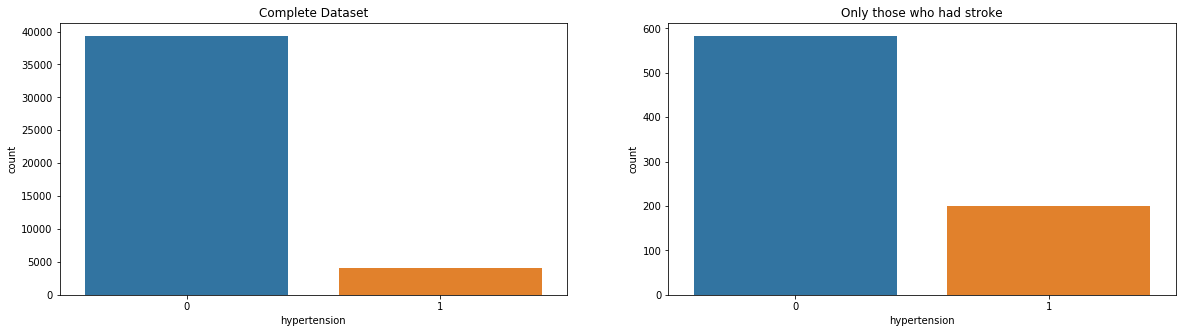

In [21]:
# Define a figure,
# so that we can make two subplots
# one for the complete dataset,
# and one for filtering the data to just those who had a stroke
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
sns.countplot(stroke_data_clean["hypertension"])
plt.title("Complete Dataset")

plt.subplot(1,2,2)
sns.countplot(stroke_data_clean[stroke_data_clean["stroke"] == 1]["hypertension"])
plt.title("Only those who had stroke")

plt.show()

In [22]:
# Get the exact number of people in each group of the entire dataset
print(stroke_data_clean["hypertension"].value_counts())

# Get the exact number of people in each group,
# after filtering to just those who had a stroke
print(stroke_data_clean[stroke_data_clean["stroke"] == 1]["hypertension"].value_counts())

0    39339
1     4061
Name: hypertension, dtype: int64
0    583
1    200
Name: hypertension, dtype: int64


In [23]:
# Get the percent of people who had hypertension from the entire dataset
full_dataset_hypertension_percent_yes = round((4061 / (39339+4061)) * 100, 2)

# Get the percent of people who had hypertension from those who had a stroke
stroke_true_hypertension_percent_yes = round((200 / (200+583)) * 100, 2)

print(f"Percent of people with hypertension (full dataset): {full_dataset_hypertension_percent_yes}")
print(f"Percent of people with hypertension (only those with stroke): {stroke_true_hypertension_percent_yes}")

Percent of people with hypertension (full dataset): 9.36
Percent of people with hypertension (only those with stroke): 25.54


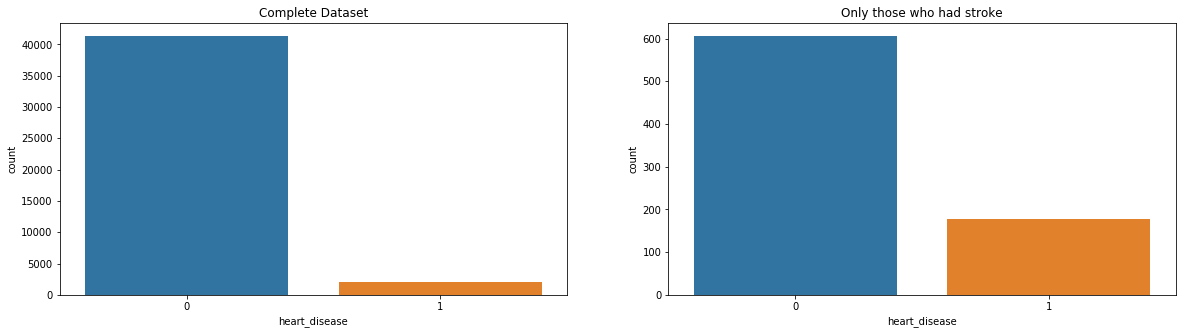

In [24]:
# Define a figure,
# so that we can make two subplots
# one for the complete dataset,
# and one for filtering the data to just those who had a stroke
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
sns.countplot(stroke_data_clean["heart_disease"])
plt.title("Complete Dataset")

plt.subplot(1,2,2)
sns.countplot(stroke_data_clean[stroke_data_clean["stroke"] == 1]["heart_disease"])
plt.title("Only those who had stroke")

plt.show()

In [25]:
# Get the exact number of people in each group of the entire dataset
print(stroke_data_clean["heart_disease"].value_counts())

# Get the exact number of people in each group,
# after filtering to just those who had a stroke
print(stroke_data_clean[stroke_data_clean["stroke"] == 1]["heart_disease"].value_counts())

0    41338
1     2062
Name: heart_disease, dtype: int64
0    606
1    177
Name: heart_disease, dtype: int64


In [26]:
# Get the percent of people who had heart disease from the entire dataset
full_dataset_heart_disease_percent_yes = round((2062 / (41338+2062)) * 100, 2)

# Get the percent of people who had heart disease from those who had a stroke
stroke_true_heart_disease_percent_yes = round((177 / (606+177)) * 100, 2)

print(f"Percent of people with heart disease (full dataset): {full_dataset_heart_disease_percent_yes}")
print(f"Percent of people with heart disease (only those with stroke): {stroke_true_heart_disease_percent_yes}")

Percent of people with heart disease (full dataset): 4.75
Percent of people with heart disease (only those with stroke): 22.61


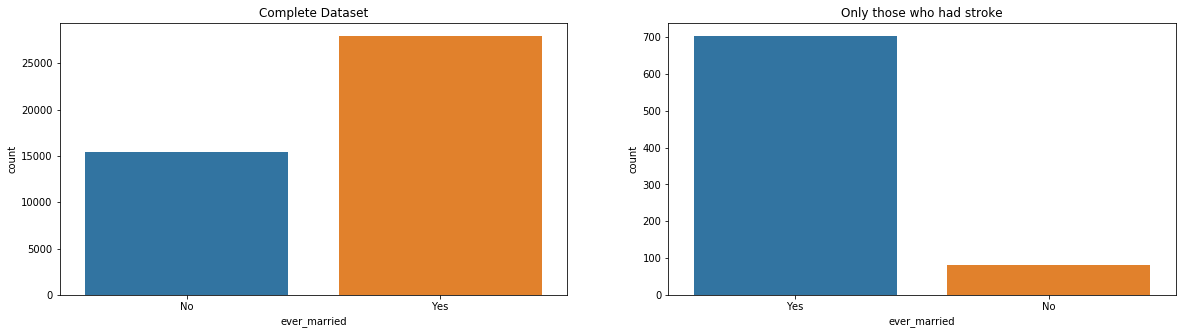

In [27]:
# Define a figure,
# so that we can make two subplots
# one for the complete dataset,
# and one for filtering the data to just those who had a stroke
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
sns.countplot(stroke_data_clean["ever_married"])
plt.title("Complete Dataset")

plt.subplot(1,2,2)
sns.countplot(stroke_data_clean[stroke_data_clean["stroke"] == 1]["ever_married"])
plt.title("Only those who had stroke")

plt.show()

In [28]:
# Get the exact number of people in each group of the entire dataset
print(stroke_data_clean["ever_married"].value_counts(), "\n")

# Get the exact number of people in each group,
# after filtering to just those who had a stroke
print(stroke_data_clean[stroke_data_clean["stroke"] ==1]["ever_married"].value_counts())

Yes    27938
No     15462
Name: ever_married, dtype: int64 

Yes    703
No      80
Name: ever_married, dtype: int64


In [29]:
# Get the percent of people who were ever married from the entire dataset
full_dataset_ever_married_percent_yes = round((27938 / (15462+27938)) * 100, 2)

# Get the percent of people who were ever married from those who had a stroke
stroke_true_ever_married_percent_yes = round((703 / (80+703)) * 100, 2)

print(f"Percent of people ever married (full dataset): {full_dataset_ever_married_percent_yes}")
print(f"Percent of people ever married (only those with stroke): {stroke_true_ever_married_percent_yes}")

Percent of people ever married (full dataset): 64.37
Percent of people ever married (only those with stroke): 89.78


Text(0.5,1,'Only those who had stroke')

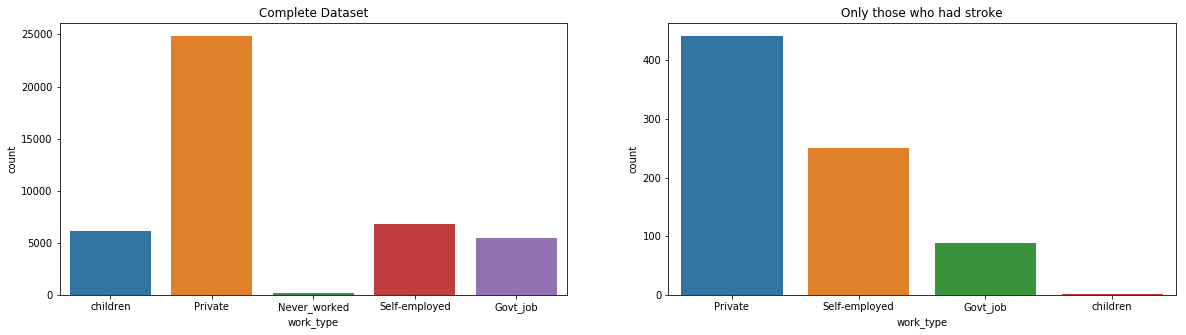

In [30]:
# Define a figure,
# so that we can make two subplots
# one for the complete dataset,
# and one for filtering the data to just those who had a stroke
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
sns.countplot(stroke_data_clean["work_type"])
plt.title("Complete Dataset")

plt.subplot(1,2,2)
sns.countplot(stroke_data_clean[stroke_data_clean["stroke"] == 1]["work_type"])
plt.title("Only those who had stroke")

In [31]:
# Get the exact number of people in each group of the entire dataset
print(stroke_data_clean["work_type"].value_counts(), "\n")

# Get the exact number of people in each group,
# after filtering to just those who had a stroke
print(stroke_data_clean[stroke_data_clean["stroke"] == 1]["work_type"].value_counts())

Private          24834
Self-employed     6793
children          6156
Govt_job          5440
Never_worked       177
Name: work_type, dtype: int64 

Private          441
Self-employed    251
Govt_job          89
children           2
Name: work_type, dtype: int64


In [32]:
# Get the percent of people of each work type from the entire dataset
full_data_work_type_percent_private = round((24834 / (24834 + 6793 + 6156 + 5440 + 177)) * 100, 2)
full_data_work_type_percent_self_employed = round((6793 / (24834 + 6793 + 6156 + 5440 + 177)) * 100, 2)
full_data_work_type_percent_children = round((6156 / (24834 + 6793 + 6156 + 5440 + 177)) * 100, 2)
full_data_work_type_percent_govt_job = round((5440 / (24834 + 6793 + 6156 + 5440 + 177)) * 100, 2)

# Get the percent of people of each work type from those who had a stroke
stroke_true_work_type_percent_private = round((441 / (441 + 251 + 89 + 2)) * 100, 2)
stroke_true_work_type_percent_self_employed = round((251 / (441 + 251 + 89 + 2)) * 100, 2)
stroke_true_work_type_percent_govt_job = round((89 / (441 + 251 + 89 + 2)) * 100, 2)
stroke_true_work_type_percent_children = round((2 / (441 + 251 + 89 + 2)) * 100, 2)

print(f"Percent of people work type private (full dataset): {full_data_work_type_percent_private}")
print(f"Percent of people work type private (only those with stroke): {stroke_true_work_type_percent_private}")
print()
print(f"Percent of people work type self employed (full dataset): {full_data_work_type_percent_self_employed}")
print(f"Percent of people work type self employed (only those with stroke): {stroke_true_work_type_percent_self_employed}")
print()
print(f"Percent of people work type children (full dataset): {full_data_work_type_percent_children}")
print(f"Percent of people work type children (only those with stroke): {stroke_true_work_type_percent_children}")
print()
print(f"Percent of people work type govt job (full dataset): {full_data_work_type_percent_govt_job}")
print(f"Percent of people work type govt job (only those with stroke): {stroke_true_work_type_percent_govt_job}")

Percent of people work type private (full dataset): 57.22
Percent of people work type private (only those with stroke): 56.32

Percent of people work type self employed (full dataset): 15.65
Percent of people work type self employed (only those with stroke): 32.06

Percent of people work type children (full dataset): 14.18
Percent of people work type children (only those with stroke): 0.26

Percent of people work type govt job (full dataset): 12.53
Percent of people work type govt job (only those with stroke): 11.37


Text(0.5,1,'Only those who had stroke')

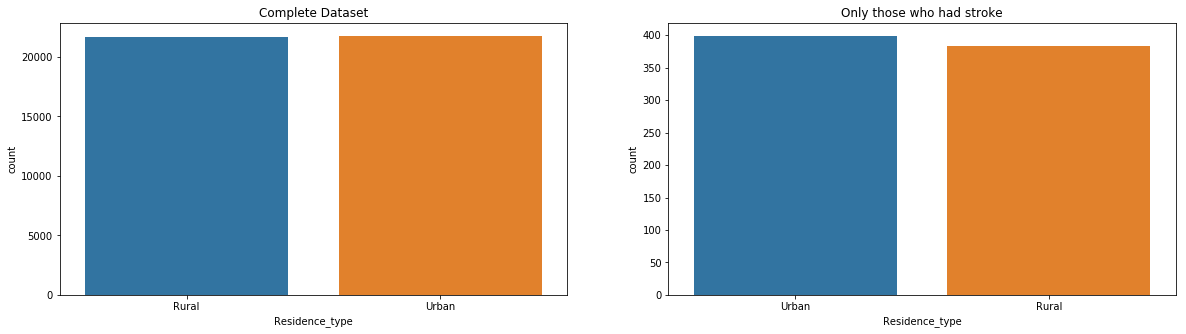

In [33]:
# Define a figure,
# so that we can make two subplots
# one for the complete dataset,
# and one for filtering the data to just those who had a stroke
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
sns.countplot(stroke_data_clean["Residence_type"])
plt.title("Complete Dataset")

plt.subplot(1,2,2)
sns.countplot(stroke_data_clean[stroke_data_clean["stroke"] == 1]["Residence_type"])
plt.title("Only those who had stroke")

In [34]:
# Get the exact number of people in each group of the entire dataset
print(stroke_data_clean["Residence_type"].value_counts(), "\n")

# Get the exact number of people in each group,
# after filtering to just those who had a stroke
print(stroke_data_clean[stroke_data_clean["stroke"] == 1]["Residence_type"].value_counts())

Urban    21756
Rural    21644
Name: Residence_type, dtype: int64 

Urban    399
Rural    384
Name: Residence_type, dtype: int64


In [35]:
# Get the percent of people with urban residence type in the entire dataset
full_data_residence_type_percent_urban = round((21756 / (21756 + 21644)) * 100, 2)

# Get the percent of people with urban residence type and had a stroke
stroke_true_resident_type_percent_urban = round((399 / (399 + 384)) * 100, 2)

print(f"Percent of people residence type urban (full dataset): {full_data_residence_type_percent_urban}")
print(f"Percent of people residence type urban (only those with stroke): {stroke_true_resident_type_percent_urban}")

Percent of people residence type urban (full dataset): 50.13
Percent of people residence type urban (only those with stroke): 50.96


Text(0.5,1,'Only those who had stroke')

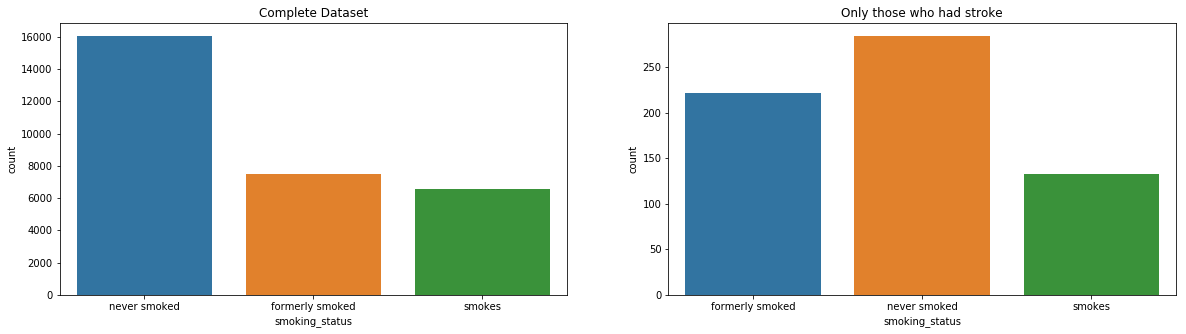

In [36]:
# Define a figure,
# so that we can make two subplots
# one for the complete dataset,
# and one for filtering the data to just those who had a stroke
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
sns.countplot(stroke_data_clean["smoking_status"])
plt.title("Complete Dataset")

plt.subplot(1,2,2)
sns.countplot(stroke_data_clean[stroke_data_clean["stroke"] == 1]["smoking_status"])
plt.title("Only those who had stroke")

In [37]:
# Get the exact number of people in each group of the entire dataset
print(stroke_data_clean["smoking_status"].value_counts(), "\n")

# Get the exact number of people in each group,
# after filtering to just those who had a stroke
print(stroke_data_clean[stroke_data_clean["stroke"] == 1]["smoking_status"].value_counts())

never smoked       16053
formerly smoked     7493
smokes              6562
Name: smoking_status, dtype: int64 

never smoked       284
formerly smoked    221
smokes             133
Name: smoking_status, dtype: int64


In [38]:
# Get the percent of people of each smoking status from the entire dataset
full_data_smoking_status_percent_never_smoked = round((16053 / (16053 + 7493 + 6562)) * 100, 2)
full_data_smoking_status_percent_formerly_smoked = round((7493 / (16053 + 7493 + 6562)) * 100, 2)
full_data_smoking_status_percent_smokes = round((6562 / (16053 + 7493 + 6562)) * 100, 2)

# Get the percent of people of each smoking status from those who had a stroke
stroke_true_smoking_status_percent_never_smoked = round((284 / (284 + 221 + 133)) * 100, 2)
stroke_true_smoking_status_percent_formerly_smoked = round((221 / (284 + 221 + 133)) * 100, 2)
stroke_true_smoking_status_percent_smokes = round((133 / (284 + 221 + 133)) * 100, 2)

print(f"Percent of people smoking_status never smoked (full dataset): {full_data_smoking_status_percent_never_smoked}")
print(f"Percent of people smoking_status never smoked (only those with stroke): {stroke_true_smoking_status_percent_never_smoked}")
print()
print(f"Percent of people smoking_status formerly smoked (full dataset): {full_data_smoking_status_percent_formerly_smoked}")
print(f"Percent of people smoking_status formerly smoked (only those with stroke): {stroke_true_smoking_status_percent_formerly_smoked}")
print()
print(f"Percent of people smoking_status smokes (full dataset): {full_data_smoking_status_percent_smokes}")
print(f"Percent of people smoking_status smokes (only those with stroke): {stroke_true_smoking_status_percent_smokes}")

Percent of people smoking_status never smoked (full dataset): 53.32
Percent of people smoking_status never smoked (only those with stroke): 44.51

Percent of people smoking_status formerly smoked (full dataset): 24.89
Percent of people smoking_status formerly smoked (only those with stroke): 34.64

Percent of people smoking_status smokes (full dataset): 21.79
Percent of people smoking_status smokes (only those with stroke): 20.85


#### Observations:

1. Males make up about 40.84% of the complete dataset, and about 44.96% of those who had a stroke.
2. Despite making up only about 9.36% of the complete dataset, those with hypertension make up about 25.54% of those who had a stroke.
3. Despite making up only about 4.75% of the complete dataset, those with heart disease make up about 22.62% of those who had a stroke.
4. Despite making up only about 64.37% of the complete dataset, those who have ever been married make up about 89.78% of those who had a stroke.
5. Despite making up only about 15.65% of the complete dataset, those who are self employed make up about 32.06% of those who had a stroke.
6. Despite making up as much as about 14.18% of the complete dataset, those whose work type is "children" make up only about 0.26% of those who had a stroke.  We we will elaborate on this in the next cell.
7. People with an urban residence type make up about 50.13% of the complete dataset, and about 50.96% of those who had a stroke.
8. Despite making up as much as about 53.32% of the complete dataset, those who have never smoked make up only 44.51% of those who had a stroke.
9. Despite making up only about 24.89% of the complete dataset, those who formerly smoked make up about 34.64% of those who had a stroke.

#### Next steps:
1. From observation 1, we do not consider gender important enough to be a feature.
2. From observtion 7, we do not consider residence_type important enough to be a feature. 
3. From observations 5, we wonder whether people who are self employed lack employer-provided health coverage and are thus more prone to having a stroke.  From observation observation 6, we notice that people whose work type is children make up a a significantly small percentage of people who have a stroke.  As "children" isn't very clear, we examine this in the following cell.  In any case, we decide to condense the groups in work_type down to "self employed," "children," and "employer emplyed."  We consider the percent-changes private and government jobs to be insignificant.

In [39]:
# In the cell above, we noticed that,
# despite making up as much as about 14.18% of the complete dataset,
# those whose work type is "children" make up only about 0.26% of those who had a stroke

# As "children" isn't very clear,
# we decide to check the max age for indiviudals with this work type

stroke_data_clean[stroke_data_clean["work_type"] == "children"]["age"].max()

16.0

We can observe from the cell above that the oldest person with work type "children" is 16- a pretty low age.  We therefore assume that a work type of "children" means "this person is a child, and has no job."

### Numerical Analysis

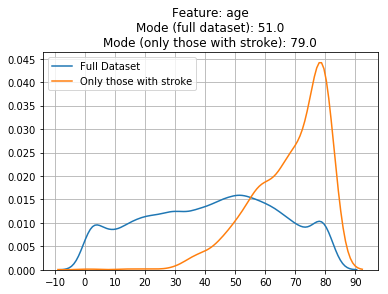

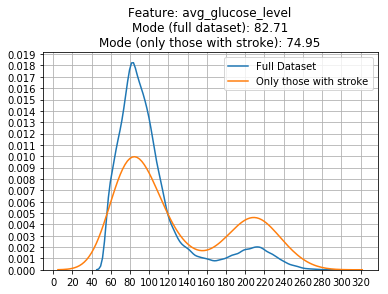

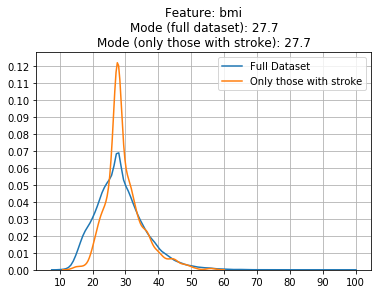

In [40]:
# Make kdeplot for each possible numerical feature
for possible_feature in possible_numerical_features:
    
    # Make two kdeplots,
    # one for the complete dataset,
    # and one for only those who had a stroke
    sns.kdeplot(stroke_data_clean[possible_feature])
    sns.kdeplot(stroke_data_clean[stroke_data_clean["stroke"] == 1][possible_feature])
    
    # Calculate the mode of the current feature,
    # (for both the complete dataset and the only-stroke-true subset)
    # To include in the plot title
    full_dataset_mode = round(stroke_data_clean.mode()[possible_feature][0], 2)
    stroke_true_mode = round(stroke_data_clean[stroke_data_clean["stroke"] == 1].mode()[possible_feature][0], 2)
    plt.title(f"Feature: {possible_feature}\nMode (full dataset): {full_dataset_mode}\nMode (only those with stroke): {stroke_true_mode}")
    
    # Find the minimum and maximum values from the current column
    # in order to calculate the range
    # Divide this range by a small number to set a new step-size for the x-axis
    column_max = stroke_data_clean[possible_feature].max()
    column_min = stroke_data_clean[possible_feature].min()
    column_range = column_max - column_min
    
    # Divide the column range by 10 for the plot showing avg_glucose_level,
    # otherwise the step-size would be too low and the x-axis would be unreadable.
    # We still want to divide the range by 5 to find the step-size for the other graphs,
    # as more x-ticks help us to more clearly see where the data lies.
    if possible_feature == "avg_glucose_level":
        plt.locator_params(nbins=column_range/10)
    else: 
        plt.locator_params(nbins=column_range/5)
        
    plt.legend(labels=["Full Dataset", "Only those with stroke"])
    
    # Include a grid to make reading exact points on the graph easier
    plt.grid()
    
    plt.show()

#### Observations:

1. When looking at the full dataset, most people appear to have an age close to 51, but when looking at only those who had a stroke, most people have an age close to 79.
2. When looking at the full dataset, most people appear to have an average glucose level (AGL) of around 82.71.  When looking at only those who had a stroke, most people have an age close to 74.95. In both cases, the frequency of AGLs drop sharply after this value, though there is a slight spike in frequency for individuals with an average glucose level just over 200. 
3. Whether you're looking at the complete dataset, or just those who had a stroke, most samples have an average BMI of somewhere around 27.7.

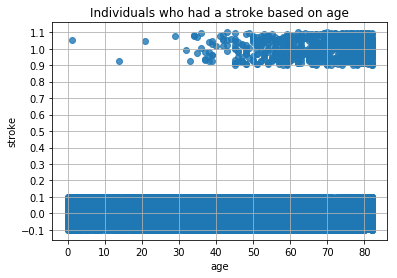

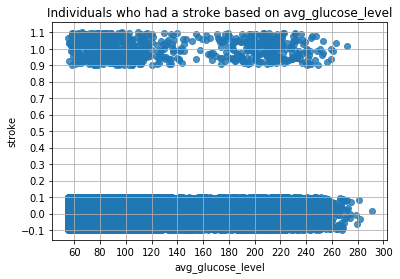

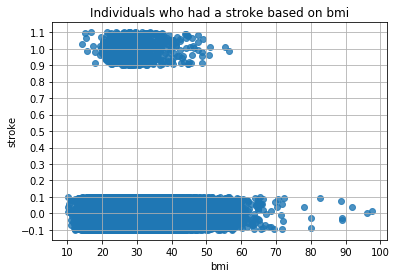

In [41]:
# Make a regplot for each potential numerical feature
for possible_feature in possible_numerical_features:
    sns.regplot(x=possible_feature, y="stroke", data=stroke_data_clean, fit_reg=False, y_jitter=0.1)
    plt.title(f"Individuals who had a stroke based on {possible_feature}")
    
    # Find the minimum and maximum values from the current column
    # in order to calculate the range
    # Divide this range by a small number to set a new step-size for the x-axis
    column_max = stroke_data_clean[possible_feature].max()
    column_min = stroke_data_clean[possible_feature].min()
    column_range = column_max - column_min
    
    # Divide the column range by 10 for the plot showing avg_glucose_level,
    # otherwise the step-size would be too low and the x-axis would be unreadable.
    # We still want to divide the range by 5 to find the step-size for the other graphs,
    # as more x-ticks help us to more clearly see where the data lies.
    if possible_feature == "avg_glucose_level":
        plt.locator_params(nbins=column_range/10)
    else: 
        plt.locator_params(nbins=column_range/5)
    
    plt.grid()
    plt.show()

#### Observations:

1. Those who did not have a stroke could be any age, while those who did have a stroke are most heavily concentrated in the 50+ years age group.  There is a smaller but still sizable number of people in the range of 40-50 years old, and an even smaller but still sizable number of people in the range of 30-40 years old.  Very few people below the age of 30 had a stroke.


2. Those who did not have a stroke could have any average glucose level (AGL) in the approximate range of 60 to 260.  A smaller but still sizable number of people exceed an AGL of 260.  Those who did have a stroke are concentrated in two separate ranges.

    The first range is from approximately 60 to approximately 120; the second range is from approximately 180 to approximately 240.  There is a noticeable gap between an AGL of about 120 to 180, where there are fewer data points.
    
    According to  the University of Washington, the "ideal range" for glucose levels should be between 90-160.  Glucose levels above 160 are "too high", with the severity of "too high" increasing as glucose levels increase.$^{[1]}$  This could explain the gap we see when examining those who had a stroke, as we see fewer data points in the "ideal range."


3. Those who did not have a stroke could have any BMI in the approximate range of 10 to 60.  A smaller but still sizable number of people have a BMI exceeding 60.  Very few people have a BMI exceeding 70.  Those who did have a stroke are concentrated in the approximate BMI range of 20 to 40.  Very few people have a BMI of less than 20.  A smaller but still sizeable number of people exceed a BMI of 40, and no one has a BMI over 60.

#### Next steps:

1. We are concerned about the lack of BMI values exceeding 60 for those who had a stroke, considering how many such values there are for the complete dataset, and just how high they go.  We will count how many values are 1 standard deviation above/below the mean, 2 standard deviations above/below the mean, 3 standard deviations above/below the mean, etc, and either drop or winsorize the data appropriately.

<hr>

[1]. https://depts.washington.edu/uwcoe/healthtopics/diabetes.html

In [42]:
# Calculate the mean and standard deviation BMI value
bmi_mean = stroke_data_clean["bmi"].mean()
bmi_standard_deviation = stroke_data_clean["bmi"].std()
print(f"BMI mean: {bmi_mean}\nBMI standard deviation: {bmi_standard_deviation}", "\n")

BMI mean: 28.57455069124366
BMI standard deviation: 7.6397686276749255 



In [43]:
# Calculate what percent of the data is 1, 2, and 3 standard deviations from the mean
percent_of_data_1_standard_deviations_from_mean = round((len(stroke_data_clean[(stroke_data_clean["bmi"] > bmi_mean + bmi_standard_deviation)\
                                                     | (stroke_data_clean["bmi"] < bmi_mean - bmi_standard_deviation)]) / len(stroke_data_clean)) * 100, 2)

percent_of_data_2_standard_deviations_from_mean = round((len(stroke_data_clean[(stroke_data_clean["bmi"] > bmi_mean + (2 * bmi_standard_deviation))\
                                                     | (stroke_data_clean["bmi"] < bmi_mean - (2 * bmi_standard_deviation))]) / len(stroke_data_clean)) * 100, 2)

percent_of_data_3_standard_deviations_from_mean = round((len(stroke_data_clean[(stroke_data_clean["bmi"] > bmi_mean + (3 * bmi_standard_deviation))\
                                                     | (stroke_data_clean["bmi"] < bmi_mean - (3 * bmi_standard_deviation))]) / len(stroke_data_clean)) * 100, 2)

print(f"Percent of data 1 standard deviation from mean: {percent_of_data_1_standard_deviations_from_mean}")
print(f"Percent of data 2 standard deviations from mean: {percent_of_data_2_standard_deviations_from_mean}")
print(f"Percent of data 3 standard deviations from mean: {percent_of_data_3_standard_deviations_from_mean}")

Percent of data 1 standard deviation from mean: 28.89
Percent of data 2 standard deviations from mean: 4.01
Percent of data 3 standard deviations from mean: 1.03


##### Chebyshev's rule strikes again!!!

If we transformed all data 1 standard deviation from the mean, we would effect about 28.89% of the data; if we transformed all data 2 standard deviations from the mean, we would effect about 4.01% of the data, and if we transformed all data 3 standard deviations from the mean, we would effect about 1.03% of our data.  We will take a moment to examine how much data we would affect, if we were to transform data $x$ standard deviations from the mean, where $x$ is in the range of [1, 6].

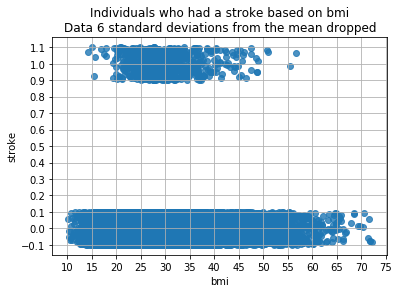

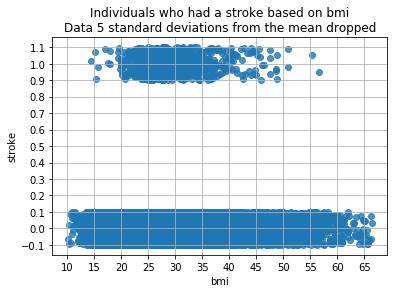

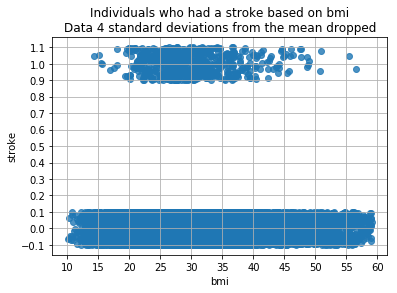

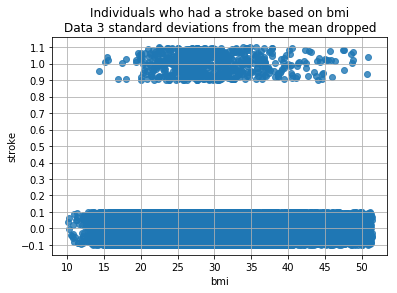

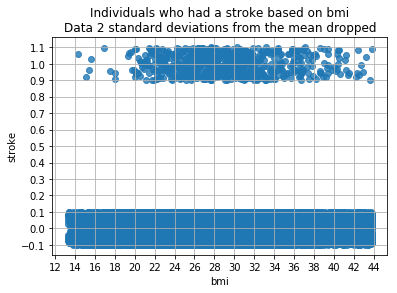

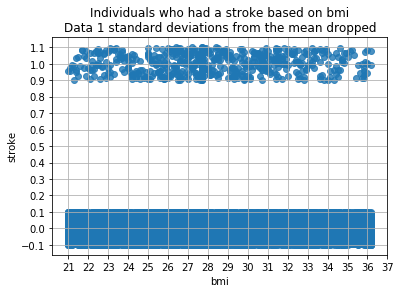

In [44]:
# Reverse our range so that the loop uses the highest value first, and the lowest value last
for i in reversed(range(6)):
 
    # Filter the data to only that within x standard deviations of the mean,
    # where x is in the range of [1, 6]
    stroke_data_x_standard_deviations_away_dropped = stroke_data_clean[(stroke_data_clean["bmi"] < bmi_mean + ((i+1) * bmi_standard_deviation))\
                                                     & (stroke_data_clean["bmi"] > bmi_mean - ((i+1) * bmi_standard_deviation))]
    
    sns.regplot(x="bmi", y="stroke", data=stroke_data_x_standard_deviations_away_dropped, fit_reg=False, y_jitter=0.1)
    plt.title(f"Individuals who had a stroke based on bmi\nData {i+1} standard deviations from the mean dropped")
    
    # Find the minimum and maximum values from the current column
    # in order to calculate the range
    # Divide this range by a small number to set a new step-size for the x-axis
    column_max = stroke_data_clean[possible_feature].max()
    column_min = stroke_data_clean[possible_feature].min()
    column_range = column_max - column_min
    
    # Divide the column range by 10 for the plot showing avg_glucose_level,
    # otherwise the step-size would be too low and the x-axis would be unreadable.
    # We still want to divide the range by 5 to find the step-size for the other graphs,
    # as more x-ticks help us to more clearly see where the data lies. 
    plt.locator_params(nbins=column_range/5)
    
    plt.grid()
    plt.show()

After examining the plots above, we determine that we should transform any data outside of 4 standard deviations from the mean.  If we transform any data outside of 3 standard deviations or less, we change valuable data, and if we transform any data outside of 5 standard deviations or more, it doesn't make a significant difference.

We will winsorize the data by capping bmi extrema to be no more than 4 standard deviations from the mean.

In [45]:
# Determine what percentage of the data is made up by that which is outside of 4 standard deviations from the mean
percent_of_data_4_standard_deviations_from_mean = round((len(stroke_data_clean[(stroke_data_clean["bmi"] > bmi_mean + (4 * bmi_standard_deviation))\
                                                     | (stroke_data_clean["bmi"] < bmi_mean - (4 * bmi_standard_deviation))]) / len(stroke_data_clean)) * 100, 2)

print(f"Percent of data 4 standard deviations from mean: {percent_of_data_4_standard_deviations_from_mean}")

Percent of data 4 standard deviations from mean: 0.24


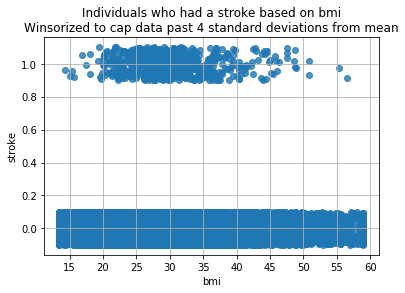

In [46]:
# import scyipy.stats so that we can winsorize the data
import scipy.stats

# The winsorize method of SciPy requires a NumPy array
# we will create a NumPy array using the bmi column
bmi_values_numpy_array = np.array(stroke_data_clean["bmi"])

# The winsorize method of scipy takes a "limits=" argument
# This argument must be a percentage in decimal format
# We already multiplied the variable percent_of_data_4_standard_deviations_from_mean by 100 when defining its value
# so we must divide by 100 for this argument to put it back in decimal format
stroke_data_clean["bmi"] = scipy.stats.mstats.winsorize(bmi_values_numpy_array,\
                                                        limits = percent_of_data_4_standard_deviations_from_mean / 100)

# Replot graph based on bmi value to confirm bmi values are properly transformed.
sns.regplot(x="bmi", y="stroke", data=stroke_data_clean, fit_reg=False, y_jitter=0.1)
plt.title("Individuals who had a stroke based on bmi\nWinsorized to cap data past 4 standard deviations from mean")

# Find the minimum and maximum values from the current column
# in order to calculate the range
# Divide this range by a small number to set a new step-size for the x-axis
column_max = stroke_data_clean[possible_feature].max()
column_min = stroke_data_clean[possible_feature].min()
column_range = column_max - column_min
    
# Divide the column range by 4 for and use this value to determine the step-size for the x-axis.
plt.locator_params(nbins=column_range/4)
plt.grid()

##### With our data now winsorized, we will re-examine  our BMI data:

1. Those who did not have a stoke could have any BMI in the approximate range of 10 to 60.  Those who did have a stroke are concentrated in the approximate BMI range of 20 to 40, where a BMI exceeding 35 is really where you <em>start</em> to see fewer people, and a BMI exceeding 40 is where you see a large decrease in the number of people.  There are also very few people who had a stroke with a BMI of less than 20.

Lastly, we will examine pairplots to see if we can notice any more trends when looking at two factors at once.

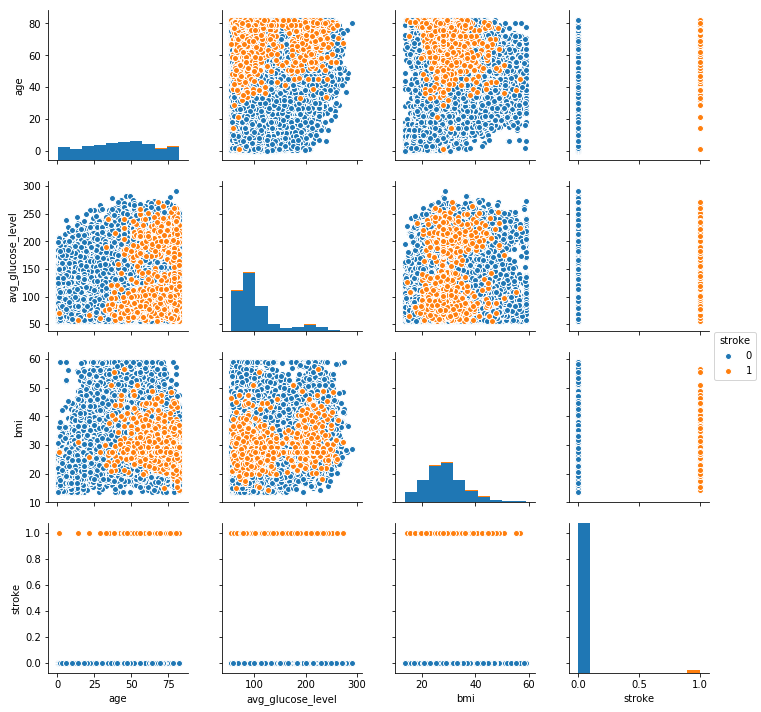

In [47]:
# Creaate a pairplot of the data
sns.pairplot(stroke_data_clean[["age", "avg_glucose_level", "bmi", "stroke"]], hue="stroke")
plt.show()

##### We can see where the people who had a stroke fall fairly well, but there is a bit of spread affecting our scales.  We will re-examine the same data on a natural- logarithmic scale for a clearer picture.

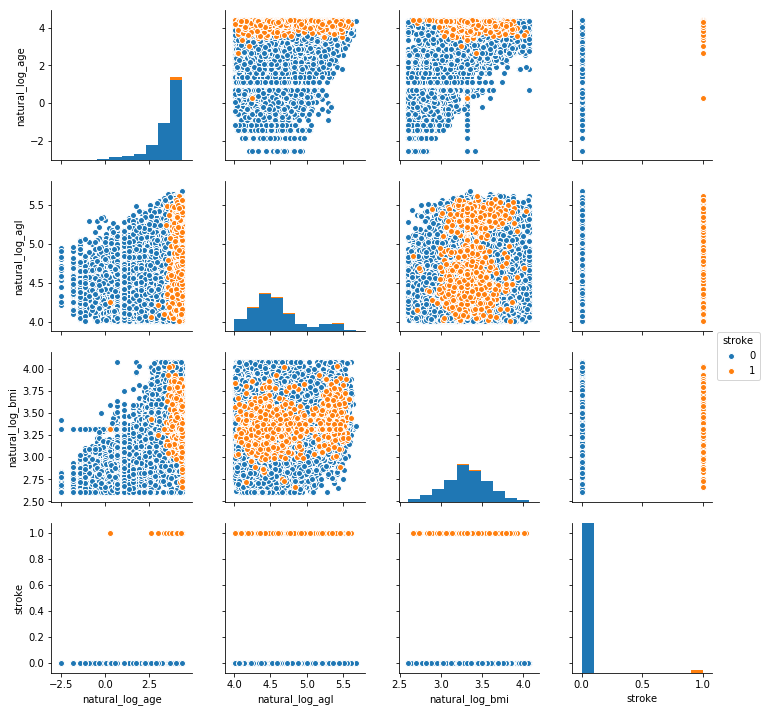

In [48]:
# Define a dataframe to hold numerical data on a natural-logarithmic scale
stroke_data_natural_log = pd.DataFrame()

# Define the columns to be the same as our current columns on a natural-logarithmic scale
stroke_data_natural_log["natural_log_age"] = np.log(stroke_data_clean["age"])
stroke_data_natural_log["natural_log_agl"] = np.log(stroke_data_clean["avg_glucose_level"])
stroke_data_natural_log["natural_log_bmi"] = np.log(stroke_data_clean["bmi"])
stroke_data_natural_log["stroke"] = stroke_data_clean["stroke"]

# Re-examine plots
sns.pairplot(stroke_data_natural_log, hue="stroke")

#### Observations:

1. Age appears to be the most important factor in determing whether a person will have a stroke.  Those who had a stroke are heavily concentrated at high ages.
2. When examining the graphs showing age vs average glucose levels (AGL) on the original scale, and the graphs showing bmi vs average glucose levels on either scale, we can see the "gaps" in AGL that we noticed earlier.  Perhaps this is the "ideal range."
3. BMI may also have some importance in determing whether a person will have a stroke.  There appears to be a very slight increase in the width of the "area" created by those who had a stroke when looking at the graph showing age vs bmi (1, 3).

## 3. Model Building

### Feature selection

From our categorical and our numerical analysis, we determine that our features should be:

#### Categorical:
1. hypertension (0 / 1)
2. heart_disease (0 / 1)
3. ever_married (0 / 1)
4. work_type (self employed / employer employed / child)
5. smoking status  (smokes / never smoked / formerly smoked)

#### Numerical:
1. age
2. average glucose level
3. bmi

In [49]:
# Condense groups in work_type down to 3 unique values: self employed, children, other
stroke_data_clean.replace(["Private", "Govt_job", "Never_worked"], "employer_employed", inplace=True)

# Confirm only three unique values for work type
stroke_data_clean["work_type"].value_counts()

employer_employed    30451
Self-employed         6793
children              6156
Name: work_type, dtype: int64

In [50]:
# Make new dataframe only including relevant features
stroke_data_relevant_features_and_label = pd.DataFrame()

# Add categorical features to dataframe
stroke_data_relevant_features_and_label["hypertension"] = stroke_data_clean["hypertension"]
stroke_data_relevant_features_and_label["heart_disease"] = stroke_data_clean["heart_disease"]
stroke_data_relevant_features_and_label["ever_married"] = stroke_data_clean["ever_married"]
stroke_data_relevant_features_and_label["work_type"] = stroke_data_clean["work_type"]
stroke_data_relevant_features_and_label["smoking_status"] = stroke_data_clean["smoking_status"]

# Add numerical features to dataframe
stroke_data_relevant_features_and_label["age"] = stroke_data_clean["age"]
stroke_data_relevant_features_and_label["average_glucose_level"] = stroke_data_clean["avg_glucose_level"]
stroke_data_relevant_features_and_label["bmi"] = stroke_data_clean["bmi"]

# Add label to dataframe
stroke_data_relevant_features_and_label["stroke"] = stroke_data_clean["stroke"]

# Preview our new dataframe
stroke_data_relevant_features_and_label.head()

,hypertension,heart_disease,ever_married,work_type,smoking_status,age,average_glucose_level,bmi,stroke
0,0,0,No,children,NaN,3.0,95.12,18.0,0
1,1,0,Yes,employer_employed,never smoked,58.0,87.96,39.2,0
2,0,0,No,employer_employed,NaN,8.0,110.89,17.6,0
3,0,0,Yes,employer_employed,formerly smoked,70.0,69.04,35.9,0
4,0,0,No,employer_employed,NaN,14.0,161.28,19.1,0


#### For consistency, we will replace the values "no" and "yes" in the ever_married column with 0 and 1, to match the format of the hypertension, heart_disease, and stroke columns.

In [51]:
# Before we replace our values, count how many "No" values and "Yes" values there are
stroke_data_relevant_features_and_label["ever_married"].value_counts()

Yes    27938
No     15462
Name: ever_married, dtype: int64

In [52]:
# For consistency, replace the value "No" with 0, and the value "Yes" with 1
stroke_data_relevant_features_and_label["ever_married"].replace("No", 0, inplace=True)
stroke_data_relevant_features_and_label["ever_married"].replace("Yes", 1, inplace=True)

# Preview new dataframe
stroke_data_relevant_features_and_label.head()

,hypertension,heart_disease,ever_married,work_type,smoking_status,age,average_glucose_level,bmi,stroke
0,0,0,0,children,NaN,3.0,95.12,18.0,0
1,1,0,1,employer_employed,never smoked,58.0,87.96,39.2,0
2,0,0,0,employer_employed,NaN,8.0,110.89,17.6,0
3,0,0,1,employer_employed,formerly smoked,70.0,69.04,35.9,0
4,0,0,0,employer_employed,NaN,14.0,161.28,19.1,0


In [53]:
# Now that we have replaced our values,
# count how many 0 values and 1 values there are
# to ensure they are still the same
stroke_data_relevant_features_and_label["ever_married"].value_counts()

1    27938
0    15462
Name: ever_married, dtype: int64

##### Our initial analysis is now complete.  We will export this dataframe as a csv file, and perform the Machine Learning in a new notebook.

In [54]:
import os

# Define export file path to Data directorty
export_file_path = os.path.join("..", "Data", "stroke_data_relevant_features_and_label.csv")

# Export final DataFrame as csv
stroke_data_relevant_features_and_label.to_csv(export_file_path, index=False, header=True)